In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
from research.strings import INSPECTION_ID, PREDICTORS
from research.evaluation import evaluate_model, show_roc, show_prc

In [3]:
df = pd.read_csv("data/inspections_train.csv")
print("Read {} records.".format(len(df)))

Read 17075 records.


In [4]:
def get_violation_codes(report):
    if pd.isnull(report):
        return []
    else:
        codes = [int(comment.split(".")[0]) for comment in report.split(" | ")]
        return codes
        

def get_violation_level(code):
    if code <= 14:
        return "critical"
    elif code <= 29:
        return "serious"
    elif code <= 44 or code == 70:
        return "minor"
    else:
        return "unknown"

In [5]:
code_array = [get_violation_codes(report) for report in df["violations"].values]
code_array[10:20]

[[32, 33, 38],
 [34, 38],
 [9, 12, 24, 31, 32, 33, 34, 35, 38],
 [33],
 [33],
 [32, 35],
 [32, 35],
 [33, 36, 37],
 [31, 33, 35, 37, 43],
 [18, 32, 34, 35, 38]]

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_all = MultiLabelBinarizer()
all_vio_mat = pd.DataFrame(mlb_all.fit_transform(code_array), columns=mlb_all.classes_)
# all_vio_mat[INSPECTION_ID] = df[INSPECTION_ID]
all_vio_mat.head()

,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,70
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


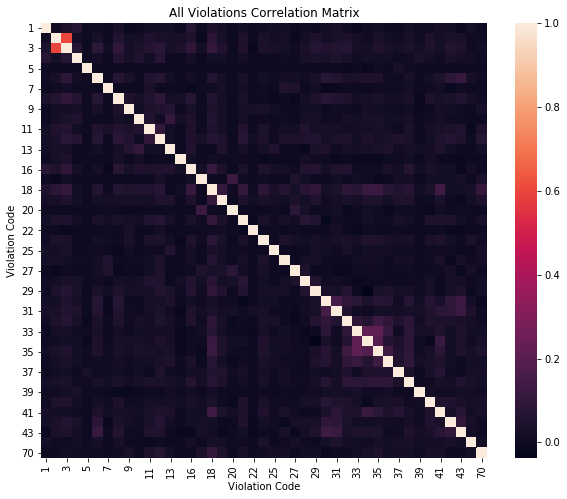

In [7]:
sns.heatmap(all_vio_mat.corr())
plt.gcf().set_size_inches(10, 8)
plt.xlabel("Violation Code")
plt.ylabel("Violation Code")
plt.title("All Violations Correlation Matrix")
plt.show()

In [8]:
crit_array = [list(filter(lambda code: get_violation_level(code) == "critical", arr)) for arr in code_array]
crit_array[10:20]

[[], [], [9, 12], [], [], [], [], [], [], []]

In [9]:
mlb_crit = MultiLabelBinarizer()
crit_mat = pd.DataFrame(mlb_crit.fit_transform(crit_array), columns=mlb_crit.classes_)
# crit_mat[INSPECTION_ID] = df[INSPECTION_ID]
crit_mat[10:20]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,1,0,0,1,0,0
13,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,0,0,0,0


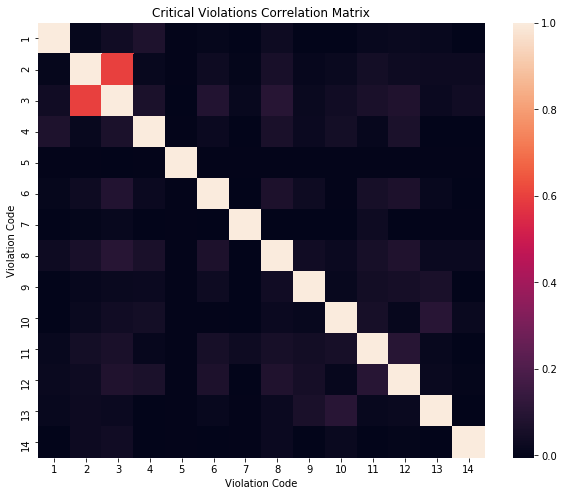

In [10]:
sns.heatmap(crit_mat.corr())
plt.gcf().set_size_inches(10, 8)
plt.xlabel("Violation Code")
plt.ylabel("Violation Code")
plt.title("Critical Violations Correlation Matrix")
plt.show()

In [11]:
cdf = pd.DataFrame(crit_mat)
cdf[INSPECTION_ID] = df[INSPECTION_ID]
ddf = pd.DataFrame(df[[INSPECTION_ID] + PREDICTORS])
vdf = cdf.set_index(INSPECTION_ID).join(ddf.set_index(INSPECTION_ID))
vp_corr = vdf.corr()[set(list(crit_mat.columns.values)) - {INSPECTION_ID}][14:]
vp_corr

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Inspector_blue,0.024136,0.073895,0.093099,0.052814,0.016930,0.096327,0.003406,0.079197,0.004130,0.008644,0.049727,0.087440,0.017759,-0.000986
Inspector_brown,-0.011080,-0.055903,-0.082884,-0.016097,-0.002690,-0.035933,-0.010070,-0.047725,-0.024041,-0.020166,-0.035100,-0.040209,-0.013928,-0.013461
Inspector_green,-0.014584,-0.006070,-0.055768,-0.026517,-0.004644,-0.051138,-0.008155,-0.027692,0.006972,-0.009401,-0.035409,-0.054465,-0.006776,-0.002513
Inspector_orange,0.007303,-0.027178,-0.029466,-0.014138,-0.004073,0.019717,-0.000445,-0.015034,0.009407,0.017069,0.017124,-0.002517,0.001433,-0.001914
Inspector_purple,0.018409,0.092698,0.232940,0.051977,-0.002079,0.021982,0.016475,0.080042,0.013951,0.028311,0.047365,0.071908,0.018673,0.019861
Inspector_yellow,-0.018499,-0.053600,-0.084189,-0.028013,-0.003362,-0.043378,0.004086,-0.044892,-0.012363,-0.019034,-0.030051,-0.035944,-0.012552,0.003977
pastSerious,0.009027,0.017591,0.026458,-0.013549,-0.002705,0.002650,-0.003612,0.019000,0.023311,0.002554,0.027049,0.017317,-0.002881,0.064469
pastCritical,0.005769,0.035775,0.046366,-0.007341,-0.001982,0.005987,-0.007418,0.032037,-0.000122,0.012623,0.017053,0.028435,0.011064,0.009019
timeSinceLast,0.002208,0.021340,0.013306,0.028107,0.006255,0.003894,0.010567,-0.000583,-0.010970,0.006139,-0.000595,0.017438,0.011201,-0.006380
ageAtInspection,-0.010549,-0.004758,-0.002153,0.010608,0.005390,0.004467,0.002792,-0.016578,-0.012339,-0.005326,-0.023571,-0.034197,-0.019214,-0.031591


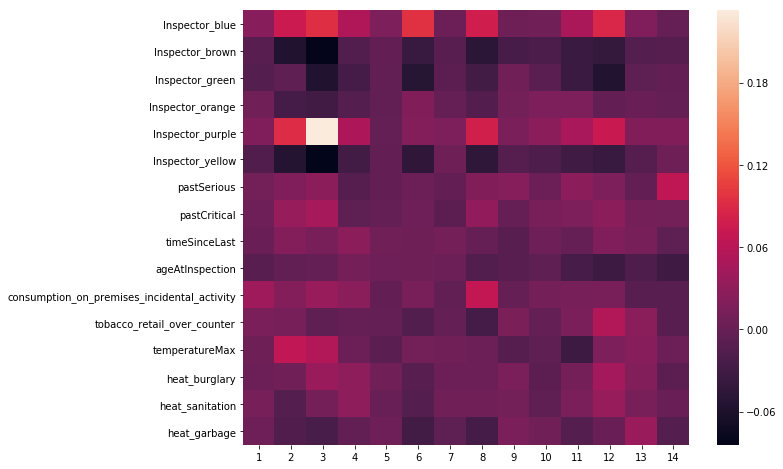

In [12]:
sns.heatmap(vp_corr)
plt.gcf().set_size_inches(10, 8)
plt.show()

In [13]:
def get_crit_mat(df):
    code_array = [get_violation_codes(report) for report in df["violations"].values]
    crit_array = [list(filter(lambda code: get_violation_level(code) == "critical", arr)) for arr in code_array]
    mlb_crit = MultiLabelBinarizer()
    crit_mat = pd.DataFrame(mlb_crit.fit_transform(crit_array), columns=mlb_crit.classes_)
    return crit_mat

In [14]:
d_train = pd.read_csv("data/inspections_train.csv")
d_test = pd.read_csv("data/inspections_test.csv")
crit_train = get_crit_mat(d_train)
crit_test = get_crit_mat(d_test)
X_train = d_train[PREDICTORS]
X_test = d_test[PREDICTORS]

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [16]:
crit_train.sum(axis=0)

1       71
2      600
3     1292
4       81
5        1
6      211
7       14
8      409
9      128
10      73
11     235
12     319
13      43
14      25
dtype: int64

In [19]:
code = 3
y_train = crit_train[:][code]
y_test = crit_test[:][code]
print("Train: P(V{0}) = {1:.3f}, N = {2}".format(code, y_train.mean(), y_train.sum()))
print("Test:  P(V{0}) = {1:.3f}, N = {2}\n".format(code, y_test.mean(), y_test.sum()))

print("Logistic Regression")
clf = LogisticRegression(solver="lbfgs", penalty="l2", class_weight="balanced", max_iter=2000)
clf.fit(X_train, y_train)
yh = clf.predict(X_test)
evaluate_model(y_test, yh)

Train: P(V3) = 0.076, N = 1292
Test:  P(V3) = 0.085, N = 139

Logistic Regression
F1 Score = 0.23771
Precision = 0.14130
Recall = 0.74820


,Predicted +,Predicted -
Actual +,104,35
Actual -,632,866


AUROC = 0.742


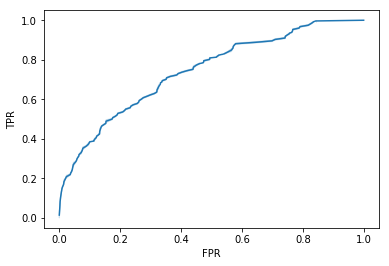

In [22]:
show_roc(clf, X_test, y_test)
show_rc(clf, X_test, y_test)

In [18]:
print("KNN")
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)
yh = clf.predict(X_test)
evaluate_model(y_test, yh)

KNN
F1 Score = 0.00000
Precision = 0.00000
Recall = 0.00000


,Predicted +,Predicted -
Actual +,0,139
Actual -,0,1498
